In [1]:
import os
from tqdm import tqdm

from fyp.crypto import Crypto


In [2]:
crypto = Crypto()


In [3]:
base = '/its/home/ep396/Documents/FYP/'
name = "dataset"


In [4]:
def load_db(name, base):
    e = base + f"encrypted_{name}.db"
    d = base + f"decrypted_{name}.db"
    crypto.age_decrypt_file(e, d)


In [5]:
def unload_db(name, base):
    e = base + f"encrypted_{name}.db"
    d = base + f"decrypted_{name}.db"
    crypto.age_encrypt_file(d, e)

    os.remove(d)


In [6]:
load_db(name, base)


In [7]:
from fyp.db_dataset import Tweet


In [8]:
query_all = Tweet.select().dicts()


# Suspicious Retweet


In [9]:
suspicious_retweet_count = []

for tweet in tqdm(query_all):
    if tweet["retweet_count"] > tweet["like_count"]:
        suspicious_retweet_count.append(tweet)


100%|██████████| 1873093/1873093 [00:27<00:00, 66918.85it/s]  


In [10]:
len(suspicious_retweet_count)


6783

In [11]:
unique_author_ids = []

for tweet in suspicious_retweet_count:
    unique_author_ids.append(tweet["author_id"])


In [12]:
len(set(unique_author_ids))


2473

In [13]:
len(suspicious_retweet_count) / len(set(unique_author_ids))


2.7428224828143954

# Suspicious Time


In [14]:
from dateutil import parser


In [15]:
times = {}

for tweet in tqdm(query_all):
    converted = parser.isoparse(tweet["created_at"]).replace(second=0, microsecond=0)
    if converted not in times:
        times[converted] = 1
    else:
        times[converted] += 1


100%|██████████| 1873093/1873093 [02:42<00:00, 11495.76it/s]


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
sns.set(rc={'figure.figsize':(40, 7)})


In [18]:
df = pd.Series(times, name='TweetCount')


<AxesSubplot:title={'center':'Tweet sum per minute within the discourse'}, xlabel='Minute', ylabel='Tweet sum'>

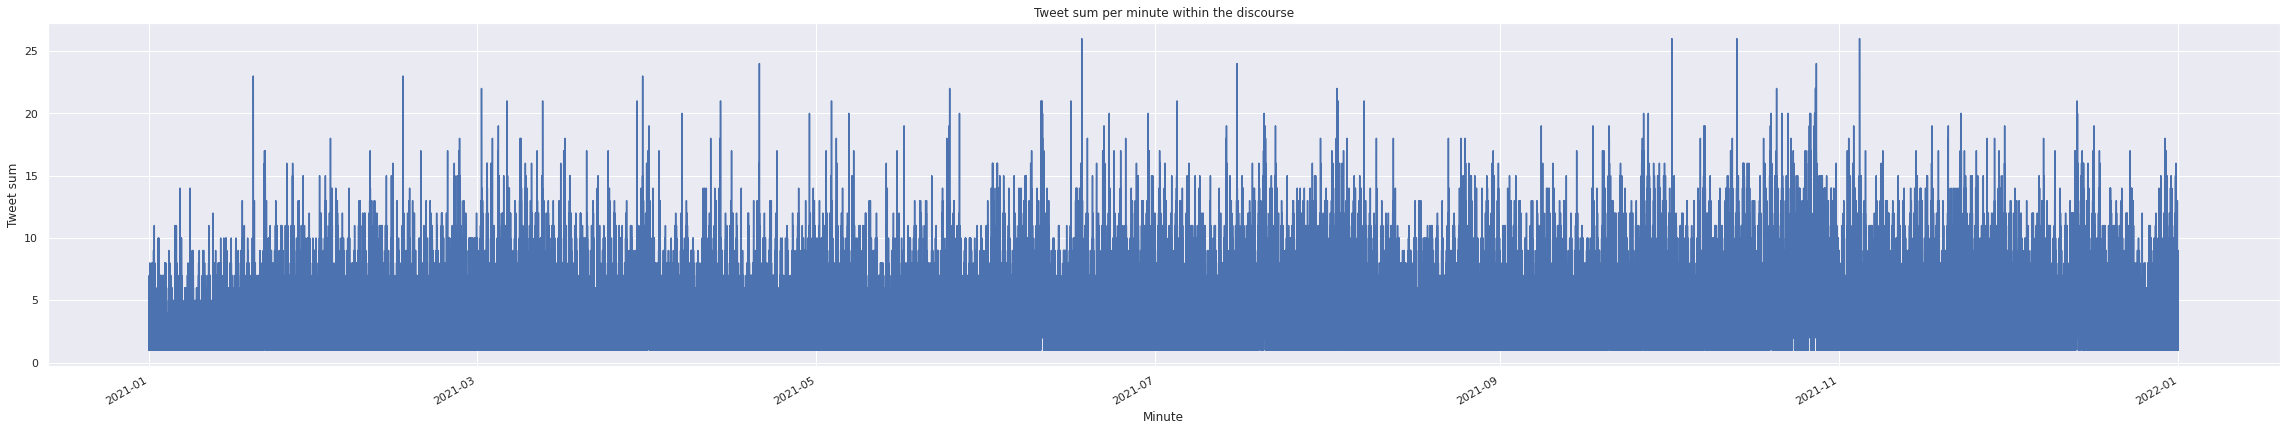

In [19]:
df.plot(xlabel="Minute", ylabel="Tweet sum", title="Tweet sum per minute within the discourse")


<AxesSubplot:title={'center':'Tweet sum per hour within the discourse'}, xlabel='Hour', ylabel='Tweet Sum'>

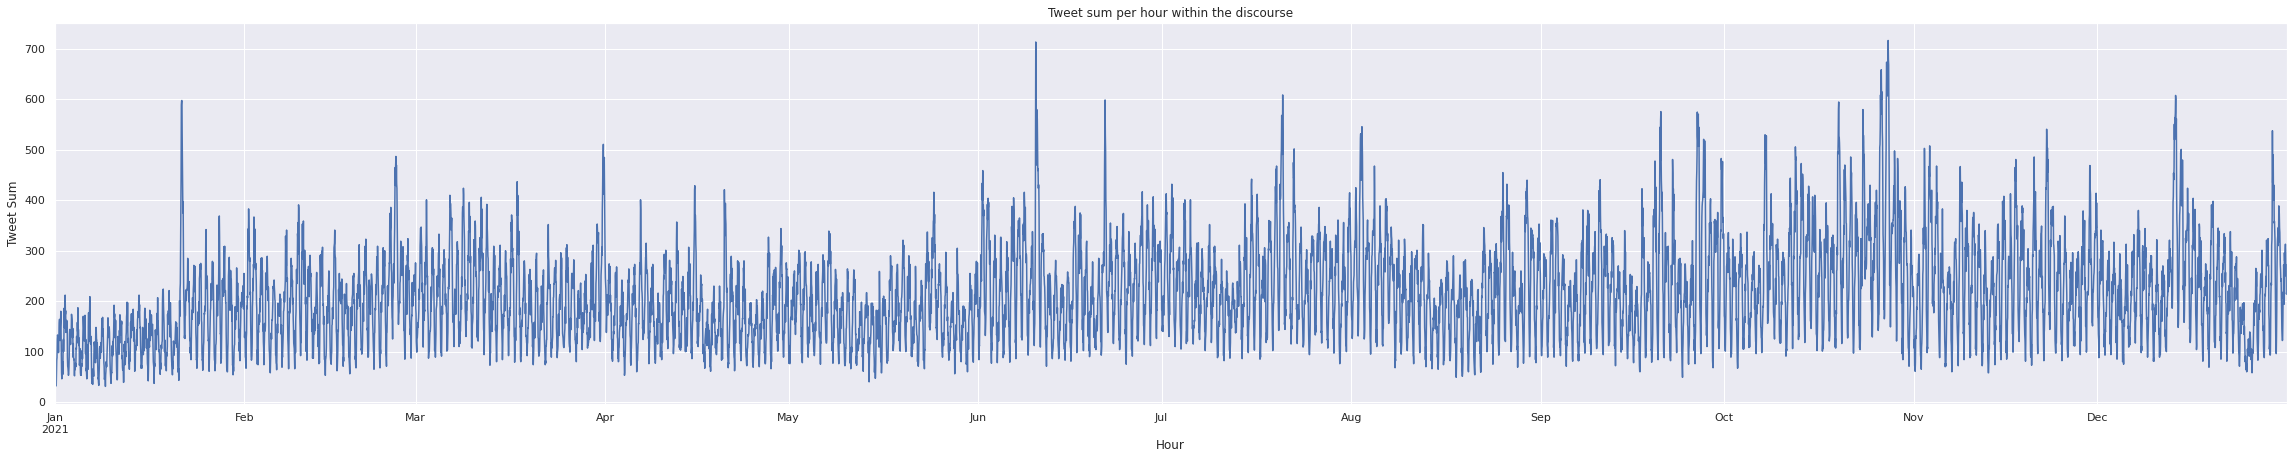

In [20]:
df.resample("H").sum().plot(xlabel="Hour", ylabel="Tweet Sum", title="Tweet sum per hour within the discourse")


<AxesSubplot:title={'center':'Tweet sum per day within the discourse'}, xlabel='Day', ylabel='Tweet sum'>

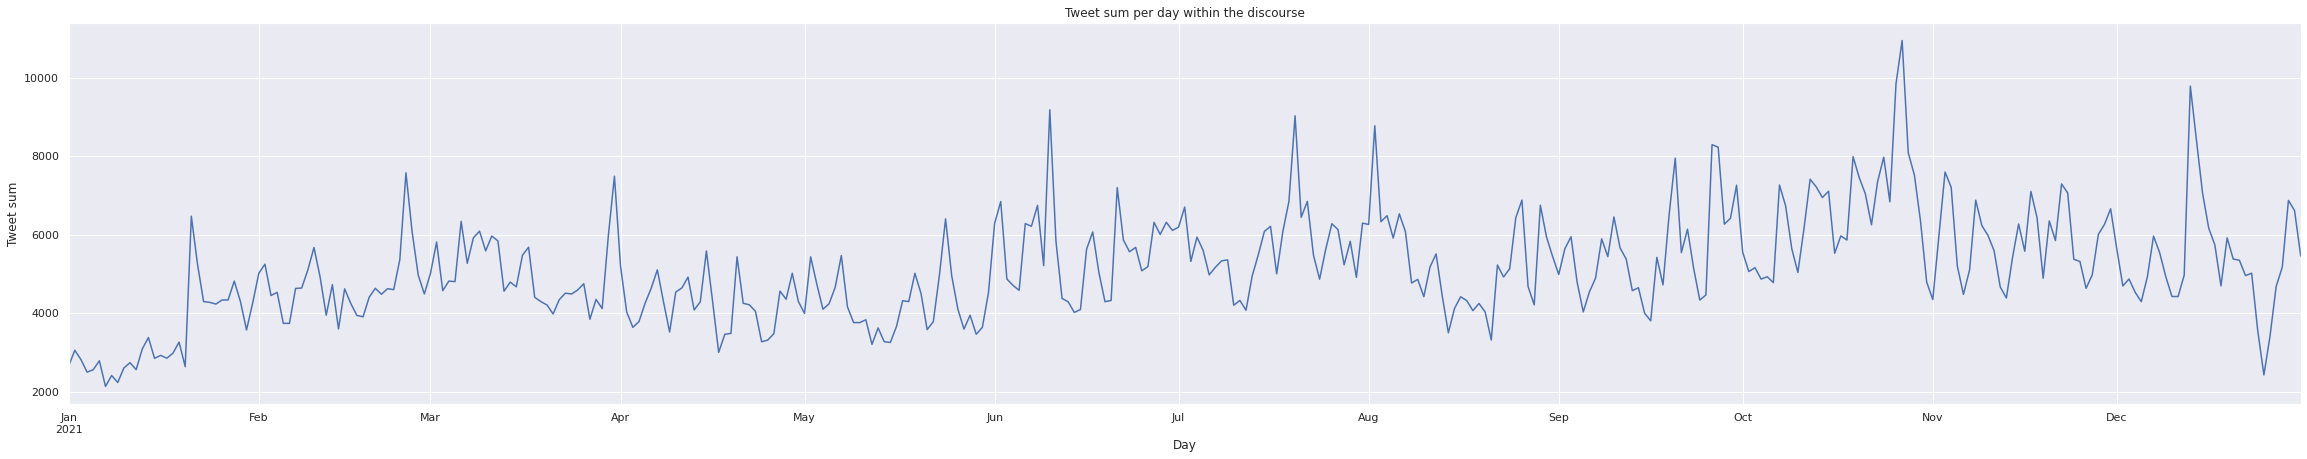

In [21]:
df.resample("D").sum().plot(xlabel="Day", ylabel="Tweet sum", title="Tweet sum per day within the discourse")


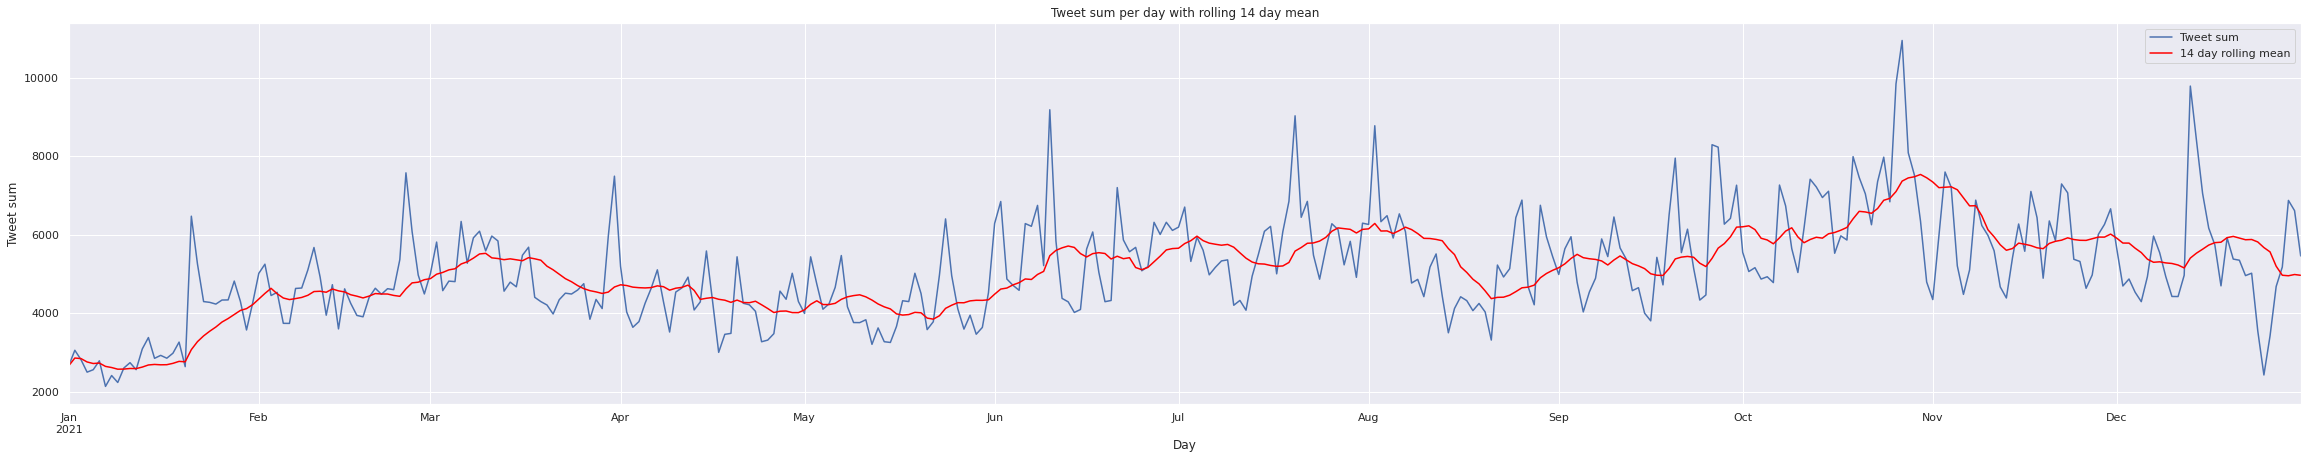

In [22]:
d_df = df.resample("D").sum()
rolling = d_df.rolling('14d').mean()
d_df.plot(xlabel="Day", ylabel="Tweet sum", label="Tweet sum", title="Tweet sum per day with rolling 14 day mean")
rolling.plot(color='red', label="14 day rolling mean")
plt.legend()
plt.show()


In [77]:
df.mean()


3.829320549121426

In [78]:
d_df.mean()


5131.761643835616

<AxesSubplot:title={'center':'Tweet sum per month within the discourse'}, xlabel='Month', ylabel='Tweet sum'>

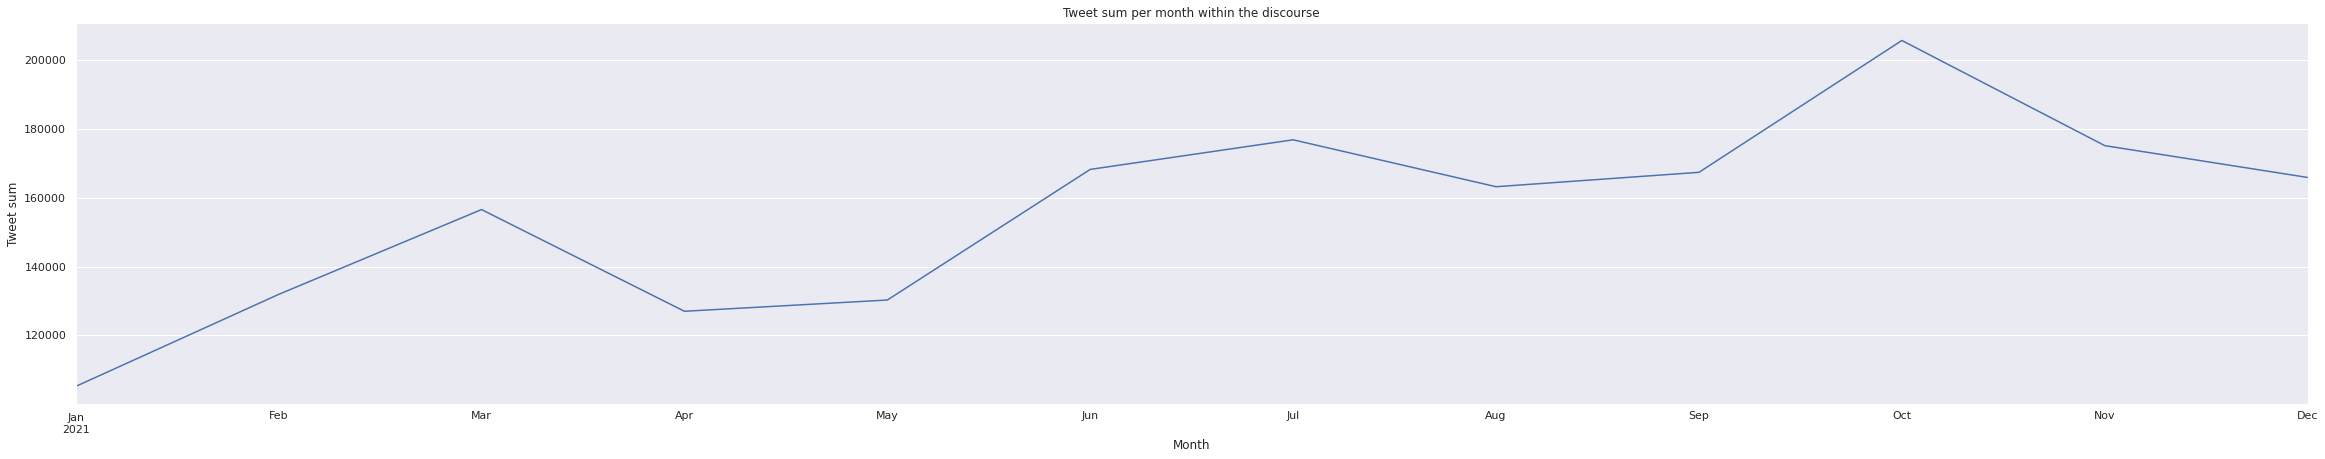

In [23]:
df.resample("M").sum().plot(xlabel="Month", ylabel="Tweet sum", title="Tweet sum per month within the discourse")


In [24]:
import numpy as np
from sklearn.linear_model import LinearRegression


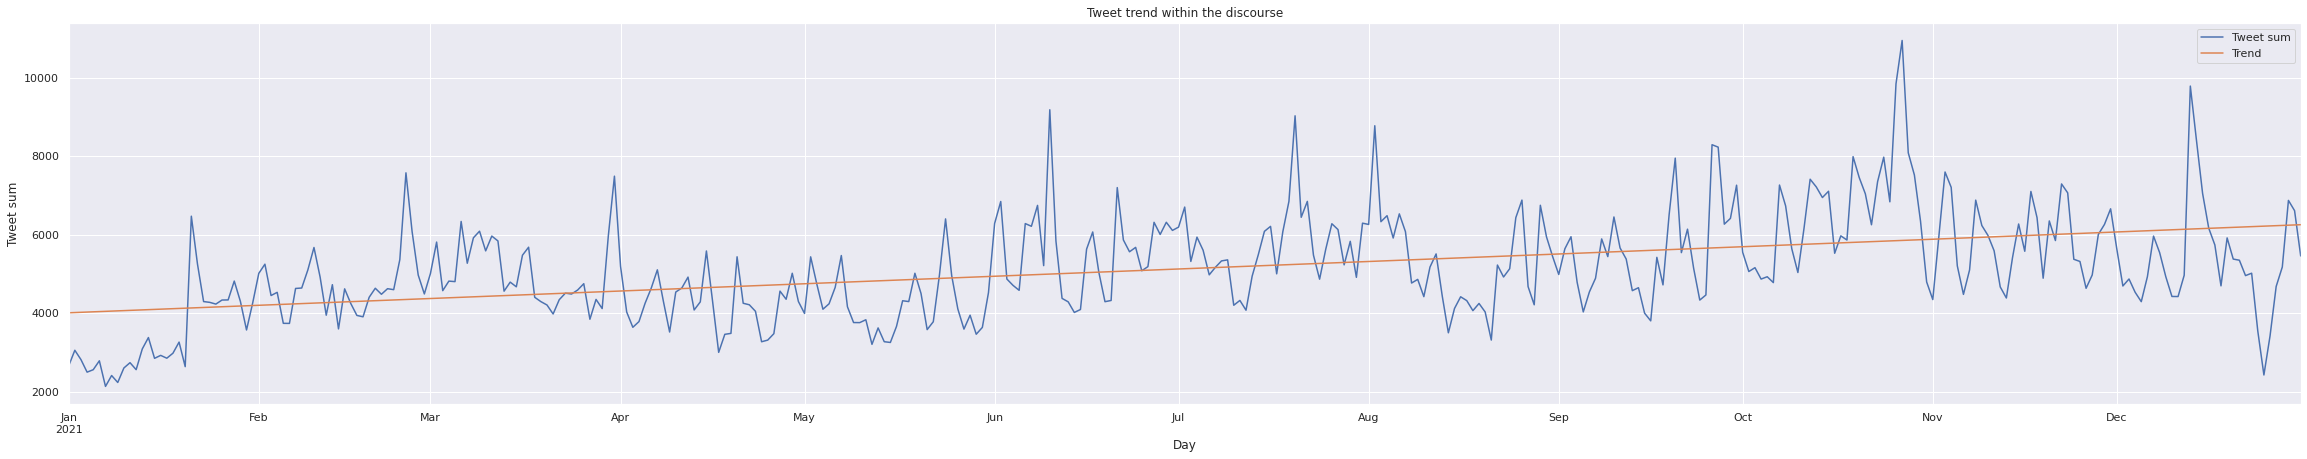

In [25]:
dd_df = d_df.to_frame()

X = [i for i in range(0, len(d_df))]
X = np.reshape(X, (len(X), 1))
y = d_df.values

model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)

dd_df['Trend'] = trend
dd_df.rename(columns = {'TweetCount':'Tweet sum'}, inplace = True)
dd_df.plot(xlabel="Day", ylabel="Tweet sum", title="Tweet trend within the discourse")

plt.show()


In [26]:
len(times)

489145

In [27]:
top_one_suspicous_times = dict(sorted(times.items(), key=lambda x:x[1], reverse=True)[:int(len(times) * 0.001)])


In [28]:
len(top_one_suspicous_times)


489

In [29]:
top_one_suspicous_times


{datetime.datetime(2021, 6, 17, 18, 11, tzinfo=tzutc()): 26,
 datetime.datetime(2021, 10, 1, 21, 56, tzinfo=tzutc()): 26,
 datetime.datetime(2021, 10, 13, 14, 13, tzinfo=tzutc()): 26,
 datetime.datetime(2021, 11, 4, 16, 8, tzinfo=tzutc()): 26,
 datetime.datetime(2021, 4, 20, 18, 27, tzinfo=tzutc()): 24,
 datetime.datetime(2021, 7, 15, 16, 54, tzinfo=tzutc()): 24,
 datetime.datetime(2021, 10, 27, 21, 39, tzinfo=tzutc()): 24,
 datetime.datetime(2021, 1, 19, 17, 28, tzinfo=tzutc()): 23,
 datetime.datetime(2021, 2, 15, 16, 24, tzinfo=tzutc()): 23,
 datetime.datetime(2021, 3, 30, 18, 34, tzinfo=tzutc()): 23,
 datetime.datetime(2021, 3, 1, 18, 49, tzinfo=tzutc()): 22,
 datetime.datetime(2021, 5, 25, 0, 4, tzinfo=tzutc()): 22,
 datetime.datetime(2021, 8, 2, 16, 2, tzinfo=tzutc()): 22,
 datetime.datetime(2021, 10, 20, 18, 3, tzinfo=tzutc()): 22,
 datetime.datetime(2021, 10, 27, 17, 55, tzinfo=tzutc()): 22,
 datetime.datetime(2021, 10, 27, 19, 36, tzinfo=tzutc()): 22,
 datetime.datetime(2021, 3

In [30]:
len(top_one_suspicous_times)


489

In [31]:
import datetime
one_minute = datetime.timedelta(minutes=1)


In [32]:
suspicous_times_tweets = {}

for tweet in tqdm(query_all):
    converted = parser.isoparse(tweet["created_at"]).replace(second=0, microsecond=0)
    converted_plus_one = parser.isoparse(tweet["created_at"]) + one_minute
    converted_minus_one = parser.isoparse(tweet["created_at"]) - one_minute
    if converted in top_one_suspicous_times or converted_plus_one in top_one_suspicous_times or converted_minus_one in top_one_suspicous_times:
        if converted not in suspicous_times_tweets:
            suspicous_times_tweets[converted] = [tweet]
        else:
            suspicous_times_tweets[converted].append(tweet)


100%|██████████| 1873093/1873093 [04:24<00:00, 7086.12it/s] 


In [33]:
count = 0
unique_times_author_ids_all = []
unique_times_author_ids_time = {}


for time, tweets in suspicous_times_tweets.items():
    unique_times_author_ids_time[time] = []
    for tweet in tweets:
        count += 1

        author = tweet["author_id"]
        unique_times_author_ids_all.append(author)

        if author not in unique_times_author_ids_time[time]:
            unique_times_author_ids_time[time].append(tweet["author_id"])

unique_times_author_ids_all = list(set(unique_times_author_ids_all))
count


8547

In [34]:
count / len(suspicous_times_tweets)


13.785483870967742

In [35]:
count 


8547

In [36]:
len(unique_times_author_ids_all)


3236

In [37]:
sum([1 for time, users in unique_times_author_ids_time.items() for user in users])


6697

# Suspicious Text

In [10]:
from farmhash import FarmHash64
from nltk.tokenize import RegexpTokenizer
import html
import re

regex_tokenizer = RegexpTokenizer(r'\w+')


def clean_text(text):
    escaped_text = html.unescape(text.lower())
    removed_links = re.sub(r"https?://\S+", "", escaped_text)
    removed_mentions = re.sub(r"(^|[^@\w])@(\w{1,15})\b", "", removed_links)
    stripped = removed_mentions.strip()
    tokenized = regex_tokenizer.tokenize(stripped)

    return " ".join(tokenized) 


In [11]:
x = 5


In [12]:
hash_dict = {}
hash_counts = {}

for tweet in tqdm(query_all):
    hashed_text = FarmHash64(clean_text(tweet["text"]))
    if hashed_text not in hash_counts:
        hash_counts[hashed_text] = 1
    else:
        hash_counts[hashed_text] += 1
        if hash_counts[hashed_text] >= x:
            if hashed_text not in hash_dict:
                hash_dict[hashed_text] = [tweet]
            else:
                hash_dict[hashed_text].append(tweet)


100%|██████████| 1873093/1873093 [01:37<00:00, 19152.72it/s]


In [13]:
len(hash_dict)


2803

In [14]:
len(hash_counts)


1824032

In [15]:
sorted_hash_count = sorted(hash_counts.items(), key=lambda x:x[1], reverse=True)


In [16]:
dict(sorted_hash_count[:100])


{5903864488577451091: 808,
 17646564505768573973: 239,
 16233282189622733864: 230,
 1695793833045512564: 226,
 3483110161047438146: 198,
 8352421444773278037: 188,
 7440940610655914538: 162,
 10021843343538378518: 160,
 10665908892098634079: 155,
 5483165381188105532: 154,
 14507623031849547331: 144,
 6640096236978822304: 138,
 8407397864098238234: 132,
 14553660885481400394: 131,
 1051332437556302449: 129,
 5655068384144070606: 129,
 5646204674495952809: 125,
 11331207302906036949: 122,
 5457929571029719626: 120,
 3977434765628683864: 119,
 7148055325934078268: 116,
 14679722137078609996: 116,
 15185022830565473076: 113,
 2931553196361876726: 113,
 12910252204787840272: 111,
 59352138355329244: 107,
 9080724338914487419: 106,
 1309125675391950481: 102,
 8597547542461324270: 101,
 15867927567002140584: 101,
 12809794576084711013: 99,
 628796100208613242: 98,
 2565843198353264371: 96,
 3788141096113151049: 95,
 4509228959273368883: 93,
 5243458643833589582: 92,
 3053336476982505455: 92,

In [17]:
hash_id = []
count = []

for idx, pair in enumerate(sorted_hash_count, 1):
    hash_id.append(str(idx))
    count.append(pair[1])


In [18]:
cap = 100


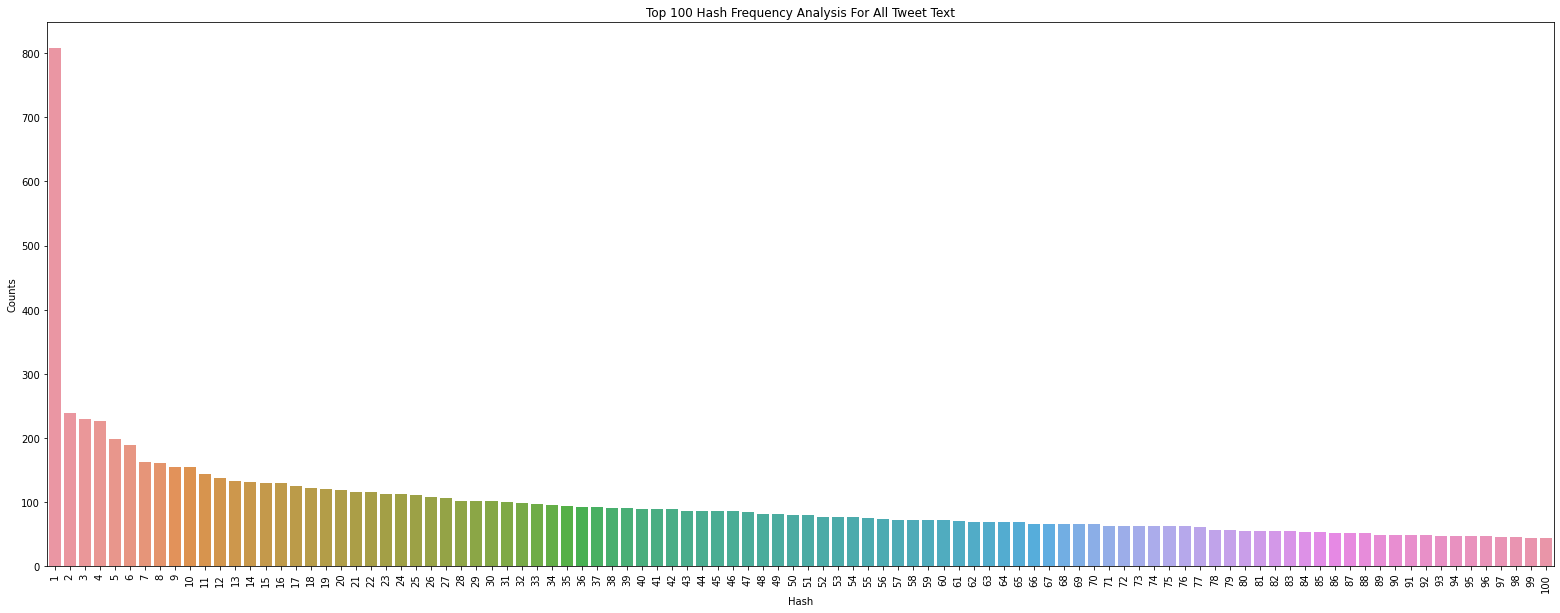

In [19]:
fig, ax = plt.subplots(figsize=(27,10))
all_plot = sns.barplot(x=hash_id[:cap], y=count[:cap], ax=ax)
ax.set(xlabel="Hash", ylabel="Counts")
ax.set_title("Top 100 Hash Frequency Analysis For All Tweet Text")
plt.xticks(rotation=90)
plt.show()


In [20]:
multi_hash = dict(sorted(hash_dict.items(), key=lambda x:len(x[1]), reverse=True))


In [ ]:
for idx, pair in enumerate(multi_hash.items(), start=1):
    hash_, items = pair
    if len(items) < 15:
        break
    else:
        print(idx, ",", "count =", len(items), ":", clean_text(items[0]['text']))


In [22]:
neutral = ["trans", "enby", "transgender", "nonbinary"]
non_neutral = ["genderist", "genderism", "gender cult", "adult human female", "#sexnotgender", "#istandwithjkRowling", "#sexmatters", "#biologynotbigotry", "#waronwomen", "#istandWithJKR", "gender critical", "#istandwithmayaforstater"]


In [23]:
all_category_count = {"neutral":0, "non-neutral":0, "both":0, "neither":0}

for tweet in tqdm(query_all):
    text = tweet["text"].lower()
    is_neutral = any(n in text for n in neutral)
    is_non_neutral = any(n in text for n in non_neutral)

    if is_neutral and is_non_neutral:
        all_category_count["both"] += 1
    elif is_neutral:
        all_category_count["neutral"] += 1
    elif is_non_neutral:
        all_category_count["non-neutral"] += 1
    else:
        all_category_count["neither"] += 1


100%|██████████| 1873093/1873093 [09:22<00:00, 3328.30it/s] 


In [24]:
all_category_count


{'neutral': 1720728, 'non-neutral': 78688, 'both': 29817, 'neither': 43860}

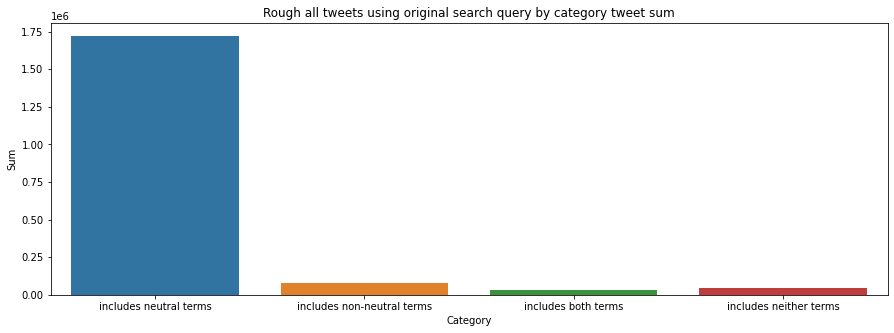

In [25]:
fig, ax = plt.subplots(figsize=(15,5))
all_plot = sns.barplot(x=["includes " + title + " terms" for title in all_category_count.keys()], y=[value for value in all_category_count.values()], ax=ax)
ax.set(xlabel="Category", ylabel="Sum")
ax.set_title("Rough all tweets using original search query by category tweet sum")
plt.show()


In [26]:
same_category_count = {"neutral":0, "non-neutral":0, "both":0, "neither":0}

for _, tweets in tqdm(multi_hash.items()):
    if len(tweets) < 15:
        break
    else:
        text = tweets[0]["text"].lower()
        is_neutral = any(n in text for n in neutral)
        is_non_neutral = any(n in text for n in non_neutral)

        if is_neutral and is_non_neutral:
            same_category_count["both"] += len(tweets)
        elif is_neutral:
            same_category_count["neutral"] += len(tweets)
        elif is_non_neutral:
            same_category_count["non-neutral"] += len(tweets)
        else:
            same_category_count["neither"] += len(tweets)


 11%|█▏        | 318/2803 [00:04<00:32, 77.31it/s] 


In [27]:
same_category_count


{'neutral': 12181, 'non-neutral': 1038, 'both': 101, 'neither': 781}

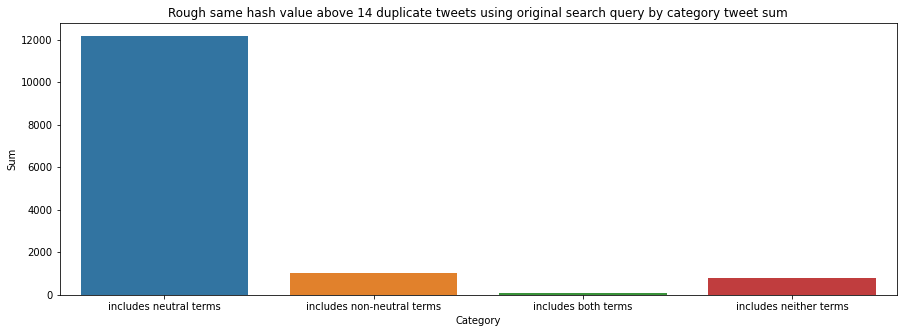

In [28]:
fig, ax = plt.subplots(figsize=(15,5))
all_plot = sns.barplot(x=["includes " + title + " terms" for title in same_category_count.keys()], y=[value for value in same_category_count.values()], ax=ax)
ax.set(xlabel="Category", ylabel="Sum")
ax.set_title("Rough same hash value above 14 duplicate tweets using original search query by category tweet sum")
plt.show()


In [29]:
non_suspicious = {k:all_category_count[k] - v for k, v in same_category_count.items()}

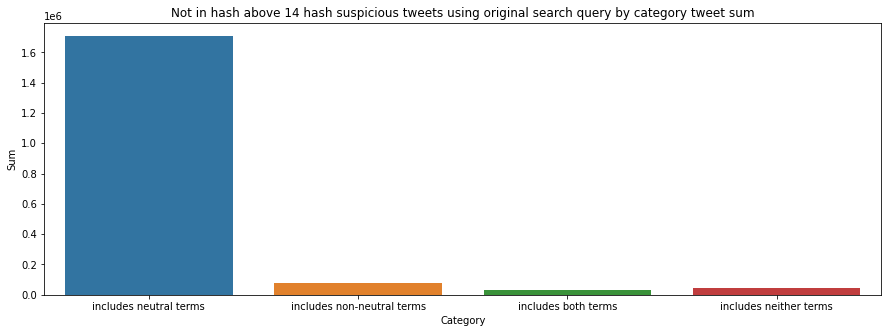

In [54]:
fig, ax = plt.subplots(figsize=(15,5))
all_plot = sns.barplot(x=["includes " + title + " terms" for title in non_suspicious.keys()], y=[value for value in non_suspicious.values()], ax=ax)
ax.set(xlabel="Category", ylabel="Sum")
ax.set_title("Not in hash above 14 hash suspicious tweets using original search query by category tweet sum")
plt.show()


In [31]:
def get_ratio(arr):
    sum_ = sum(arr)
    return [item / sum_ for item in arr]


In [32]:
non_sus_r = get_ratio([value for value in non_suspicious.values()])
non_sus_r


[0.9190717334985842,
 0.041769948445178895,
 0.015985006928485975,
 0.023173311127750954]

In [33]:
sus_r = get_ratio([value for value in same_category_count.values()])
sus_r


[0.863839444011063,
 0.07361180058151905,
 0.007162612580668038,
 0.055386142826749876]

In [34]:
[non_sus_r[i] - sus_r[i] for i in range(4)]

[0.055232289487521125,
 -0.03184185213634015,
 0.008822394347817938,
 -0.032212831698998926]

In [50]:
higher_same_category_count = {"neutral":0, "non-neutral":0, "both":0, "neither":0}

for _, tweets in tqdm(multi_hash.items()):
    if len(tweets) < 75:
        break
    else:
        text = tweets[0]["text"].lower()
        is_neutral = any(n in text for n in neutral)
        is_non_neutral = any(n in text for n in non_neutral)

        if is_neutral and is_non_neutral:
            higher_same_category_count["both"] += len(tweets)
        elif is_neutral:
            higher_same_category_count["neutral"] += len(tweets)
        elif is_non_neutral:
            higher_same_category_count["non-neutral"] += len(tweets)
        else:
            higher_same_category_count["neither"] += len(tweets)


  2%|▏         | 51/2803 [00:00<00:00, 97675.57it/s]


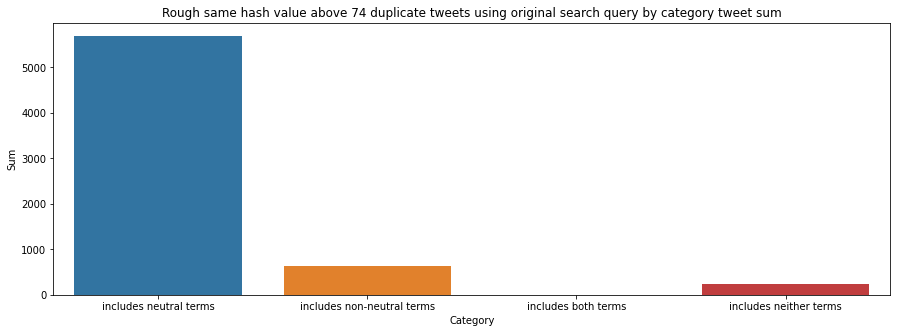

In [53]:
fig, ax = plt.subplots(figsize=(15,5))
all_plot = sns.barplot(x=["includes " + title + " terms" for title in higher_same_category_count.keys()], y=[value for value in higher_same_category_count.values()], ax=ax)
ax.set(xlabel="Category", ylabel="Sum")
ax.set_title("Rough same hash value above 74 duplicate tweets using original search query by category tweet sum")
plt.show()


In [52]:
hhh = get_ratio([value for value in higher_same_category_count.values()])
hhh


[0.8689150007630093, 0.09629177475965207, 0.0, 0.034793224477338625]

# Finding Users Across Suspicious Data


In [63]:
user_hash_appearences = {}

for _, tweets in multi_hash.items():
    for tweet in tweets:
        user_id = tweet["author_id"]
        if user_id in user_hash_appearences:
            user_hash_appearences[user_id] += 1
        else:
            user_hash_appearences[user_id] = 1


In [64]:
user_times_appearences = {}

for _, tweets in suspicous_times_tweets.items():
    for tweet in tweets:
        user_id = tweet["author_id"]
        if user_id in user_times_appearences:
            user_times_appearences[user_id] += 1
        else:
            user_times_appearences[user_id] = 1


In [65]:
top_100_hash = dict(sorted(user_hash_appearences.items(), key=lambda x:x[1], reverse=True)[:250])


In [66]:
top_100_times = dict(sorted(user_times_appearences.items(), key=lambda x:x[1], reverse=True)[:250])


In [67]:
unique_users_hash = set([u_id for u_id in top_100_hash.keys()])
unique_users_times = set([u_id for u_id in top_100_times.keys()])
unique_users_retweets = set(unique_author_ids)


In [68]:
print(len(unique_users_hash))
print(len(unique_users_times))
print(len(unique_users_retweets))


250
250
2473


In [69]:
intercetion_hash_times = unique_users_hash.intersection(unique_users_times)
intercetion_hash_retweets = unique_users_hash.intersection(unique_users_retweets)
intercetion_times_retweets = unique_users_times.intersection(unique_users_retweets)
intercetion_hash_times_retweets = intercetion_hash_times.intersection(unique_users_retweets)


In [70]:
print(len(intercetion_hash_times))
print(len(intercetion_hash_retweets))
print(len(intercetion_times_retweets))
print(len(intercetion_hash_times_retweets))


42
163
163
33


In [71]:
from fyp.db import User


In [72]:
twitter_id_to_anon = { crypto.fernet_decrypt(user.twitter_user_id) : user.id for user in tqdm(User.select()) }


100%|██████████| 14745/14745 [00:38<00:00, 383.92it/s] 


In [73]:
suspicious_users = []

for user in intercetion_hash_times_retweets:
    suspicious_users.append(twitter_id_to_anon[str(user)])


In [74]:
import json

with open("suspicious.json", "w") as outfile:
    json.dump(suspicious_users, outfile)


---


In [38]:
unload_db(name, base)
